In [2]:
library(data.table)
library(glmnet)
library(ggplot2)
library(lubridate, quietly=TRUE)
library(zoo, quietly = TRUE)
library(dplyr, quietly = TRUE)
library(GGally, quietly=TRUE)
library(caTools)
library(rpart)
library(rattle)
library(caret)
library(e1071)
library(randomForest)
library(gbm)
library(fastDummies)

### Performance Function

In [3]:
perf_dt=function(type,actual,forecast){
    name=type
    n=length(actual)
    error=actual-forecast
    mean=mean(actual)
    sd=sd(actual)
    FBias=sum(error)/sum(actual)
    MPE=sum(error/actual)/n
    MAPE=sum(abs(error/actual))/n
    RMSE=sqrt(sum(error^2))/n
    MAD=sum(abs(error))/n
    WMAPE=MAD/mean
    l=data.frame(name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE)
    return(l)
}

In order to obtain the similar measure performance, a perf_dt function is written. In addition, if target variable categorical, confusionMatrix() function will be used for understanding performance of the model.

# Pisa Dataset

Reading Test Scores
The Programme for International Student Assessment (PISA) is a test given every three years to 15-year-old students from around the world to evaluate their performance in mathematics, reading, and science. This test provides a quantitative way to compare the performance of students from different parts of the world. In this homework assignment, we will predict the reading scores of students from the United States of America on the 2009 PISA exam.

The datasets pisa2009train.csv and pisa2009test.csv contain information about the demographics and schools for American students taking the exam, derived from 2009 PISA Public-Use Data Files distributed by the United States National Center for Education Statistics (NCES). While the datasets are not supposed to contain identifying information about students taking the test, by using the data you are bound by the NCES data use agreement, which prohibits any attempt to determine the identity of any student in the datasets.

Each row in the datasets pisa2009train.csv and pisa2009test.csv represents one student taking the exam. The datasets have the following variables:

grade: The grade in school of the student (most 15-year-olds in America are in 10th grade)

male: Whether the student is male (1/0)

raceeth: The race/ethnicity composite of the student

preschool: Whether the student attended preschool (1/0)

expectBachelors: Whether the student expects to obtain a bachelor's degree (1/0)

motherHS: Whether the student's mother completed high school (1/0)

motherBachelors: Whether the student's mother obtained a bachelor's degree (1/0)

motherWork: Whether the student's mother has part-time or full-time work (1/0)

fatherHS: Whether the student's father completed high school (1/0)

fatherBachelors: Whether the student's father obtained a bachelor's degree (1/0)

fatherWork: Whether the student's father has part-time or full-time work (1/0)

selfBornUS: Whether the student was born in the United States of America (1/0)

motherBornUS: Whether the student's mother was born in the United States of America (1/0)

fatherBornUS: Whether the student's father was born in the United States of America (1/0)

englishAtHome: Whether the student speaks English at home (1/0)

computerForSchoolwork: Whether the student has access to a computer for schoolwork (1/0)

read30MinsADay: Whether the student reads for pleasure for 30 minutes/day (1/0)

minutesPerWeekEnglish: The number of minutes per week the student spend in English class

studentsInEnglish: The number of students in this student's English class at school

schoolHasLibrary: Whether this student's school has a library (1/0)

publicSchool: Whether this student attends a public school (1/0)

urban: Whether this student's school is in an urban area (1/0)

schoolSize: The number of students in this student's school

readingScore: The student's reading score, on a 1000-point scale

### Loading Dataset

In [4]:
pisa_train=read.csv("pisa_train.csv")
pisa_test=read.csv("pisa_test.csv")
pisa_train=as.data.table(pisa_train,na.rm=TRUE)
pisa_test=as.data.table(pisa_test,na.rm=TRUE)
pisa_train=na.omit(pisa_train)
pisa_test=na.omit(pisa_test)

In [5]:
pisa_train$raceeth=as.factor(as.numeric(pisa_train$raceeth))
pisa_test$raceeth=as.factor(as.numeric(pisa_test$raceeth))

In this dataset, train and test dataset were seperated. 23 features exist in the data. Train input size is 2414 and test input size is 990. Namely, both of them exceeds the lower bound(200). In addition, target variable is "readingScore". readingScores take values in between 0 to 1000, which makes the dataset labeled. 

This dataset is proper for **Linear Regression** problems. Much as there is some wheter or not question, these values will be used as numeric. The **only factorial** feature is the **raceeth** representing the race of the students.

In [6]:
str(pisa_train)

Classes 'data.table' and 'data.frame':	2414 obs. of  24 variables:
 $ grade                : int  11 10 10 10 10 10 10 10 11 9 ...
 $ male                 : int  1 0 1 0 1 0 0 0 1 1 ...
 $ raceeth              : Factor w/ 7 levels "1","2","3","4",..: 7 3 4 7 5 4 7 4 7 7 ...
 $ preschool            : int  0 1 1 1 1 1 1 1 1 1 ...
 $ expectBachelors      : int  0 1 0 1 1 1 1 0 1 1 ...
 $ motherHS             : int  1 0 1 1 1 1 1 0 1 1 ...
 $ motherBachelors      : int  1 0 0 0 1 0 0 0 0 1 ...
 $ motherWork           : int  1 1 1 0 1 1 1 0 0 1 ...
 $ fatherHS             : int  1 1 1 1 0 1 1 0 1 1 ...
 $ fatherBachelors      : int  0 0 0 0 0 0 1 0 1 1 ...
 $ fatherWork           : int  1 1 0 1 1 0 1 1 1 1 ...
 $ selfBornUS           : int  1 1 1 1 1 0 1 0 1 1 ...
 $ motherBornUS         : int  1 1 1 1 1 0 1 0 1 1 ...
 $ fatherBornUS         : int  1 1 0 1 1 0 1 0 1 1 ...
 $ englishAtHome        : int  1 1 1 1 1 0 1 0 1 1 ...
 $ computerForSchoolwork: int  1 1 1 1 1 0 1 1 1 1 ...
 $ read30M

In [7]:
str(pisa_test)

Classes 'data.table' and 'data.frame':	990 obs. of  24 variables:
 $ grade                : int  10 10 10 10 11 10 10 10 10 10 ...
 $ male                 : int  0 0 0 0 0 1 0 1 1 0 ...
 $ raceeth              : Factor w/ 7 levels "1","2","3","4",..: 7 7 1 7 7 4 7 4 7 4 ...
 $ preschool            : int  1 1 1 1 0 1 0 1 1 1 ...
 $ expectBachelors      : int  0 1 0 0 0 1 1 0 1 1 ...
 $ motherHS             : int  1 1 1 1 1 1 1 1 1 1 ...
 $ motherBachelors      : int  1 0 0 0 1 1 0 0 1 0 ...
 $ motherWork           : int  1 0 0 1 1 1 0 1 1 1 ...
 $ fatherHS             : int  1 1 1 1 1 1 1 1 1 1 ...
 $ fatherBachelors      : int  0 1 0 0 1 0 0 0 1 1 ...
 $ fatherWork           : int  0 1 0 1 1 1 1 0 1 1 ...
 $ selfBornUS           : int  1 1 1 1 1 1 1 1 1 1 ...
 $ motherBornUS         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ fatherBornUS         : int  1 1 1 1 1 1 1 1 1 1 ...
 $ englishAtHome        : int  1 1 1 1 1 1 1 1 1 1 ...
 $ computerForSchoolwork: int  1 1 1 1 1 1 1 1 1 1 ...
 $ read30M

# Penalized Regression Approaches(PRA)

### L1 Penalty with Mean Square Error measure

In order to tune lambda values, glmnet packages are used to get best lambda values for Penalized Regression. 

In [8]:
train_mat_pisa=data.matrix(pisa_train[complete.cases(pisa_train),-c("readingScore"),with=F])

result_vec_pisa=as.vector(t(pisa_train[complete.cases(pisa_train),"readingScore"]))

cvfit_pisa=cv.glmnet(train_mat_pisa,result_vec_pisa,family="gaussian",nfolds = 10,type.measure = "mse")

test_mat_pisa=data.matrix(pisa_test[complete.cases(pisa_test),-c("readingScore")])

lasso_model_pisa_mse_min <- glmnet(train_mat_pisa,result_vec_pisa, alpha = 1, lambda = cvfit_pisa$lambda.min, standardize = FALSE)
lasso_model_pisa_mse_1se <- glmnet(train_mat_pisa,result_vec_pisa, alpha = 1, lambda = cvfit_pisa$lambda.1se, standardize = FALSE)
lasso_model_pisa_mse_10th <- glmnet(train_mat_pisa,result_vec_pisa, alpha = 1, lambda = cvfit_pisa$lambda[10], standardize = FALSE)

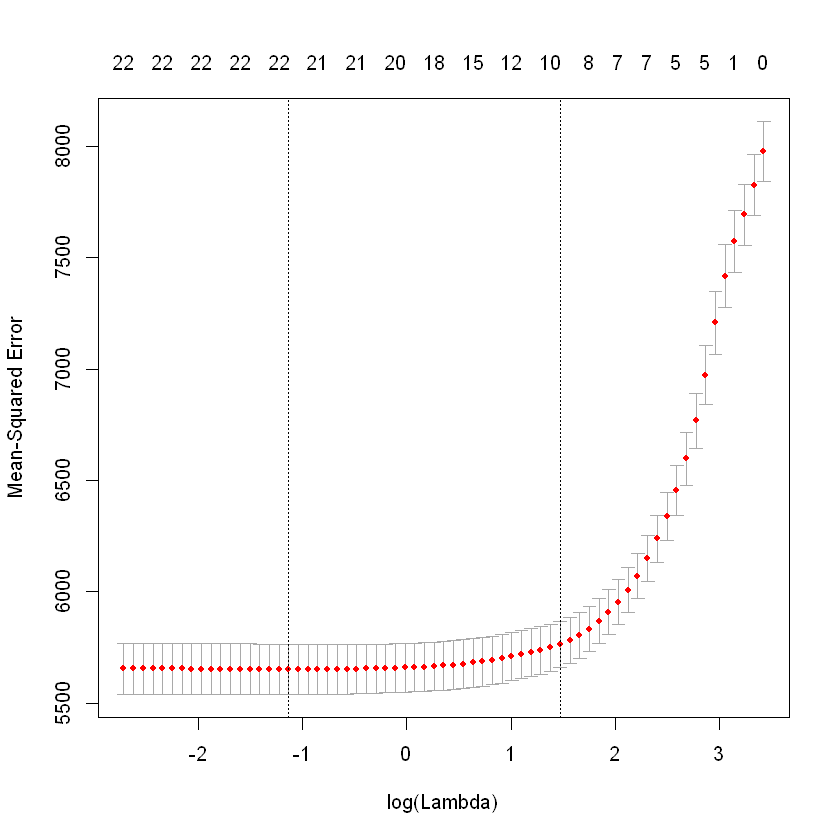

In [9]:
plot(cvfit_pisa)

### Lambda Values for Mean Square Error Values

In [10]:
cvfit_pisa$lambda.min

[1] 0.3221293

In [11]:
cvfit_pisa$lambda.1se

[1] 4.358563

In [12]:
cvfit_pisa$lambda[10]

[1] 13.31042

2 possible lambda values are determined by the cv.glmnet(). One of them is used for getting minimum Mean-Squared Error. The other one is determined by looking how many paramater is used in the model. Namely, this lambda value can be beneficial for reducing the possibility of over-fitting model on train dataset. Lastly, one random lambda was selected to compare results for these 3 lambda values.

In [13]:
prediction_pra_mse_pisa_min <- predict(lasso_model_pisa_mse_min, s = cvfit_pisa$lambda.min, newx = test_mat_pisa)
prediction_pra_mse_pisa_1se <- predict(lasso_model_pisa_mse_1se, s = cvfit_pisa$lambda.1se, newx = test_mat_pisa)
prediction_pra_mse_pisa_10th <- predict(lasso_model_pisa_mse_10th, s = cvfit_pisa$lambda[10], newx = test_mat_pisa)

## L1 Penalty with Mean Absolute Error measure

In [14]:
train_mat_pisa=data.matrix(pisa_train[complete.cases(pisa_train),-c("readingScore"),with=F])

result_vec_pisa=as.vector(t(pisa_train[complete.cases(pisa_train),"readingScore"]))

cvfit_pisa_mae=cv.glmnet(train_mat_pisa,result_vec_pisa,family="gaussian",nfolds = 10,type.measure="mae")

test_mat_pisa=data.matrix(pisa_test[complete.cases(pisa_test),-c("readingScore")])

lasso_model_pisa_mae_min <- glmnet(train_mat_pisa,result_vec_pisa, alpha = 1, lambda = cvfit_pisa_mae$lambda.min, standardize = FALSE)
lasso_model_pisa_mae_1se <- glmnet(train_mat_pisa,result_vec_pisa, alpha = 1, lambda = cvfit_pisa_mae$lambda.1se, standardize = FALSE)
lasso_model_pisa_mae_10th <- glmnet(train_mat_pisa,result_vec_pisa, alpha = 1, lambda = cvfit_pisa_mae$lambda[10], standardize = FALSE)

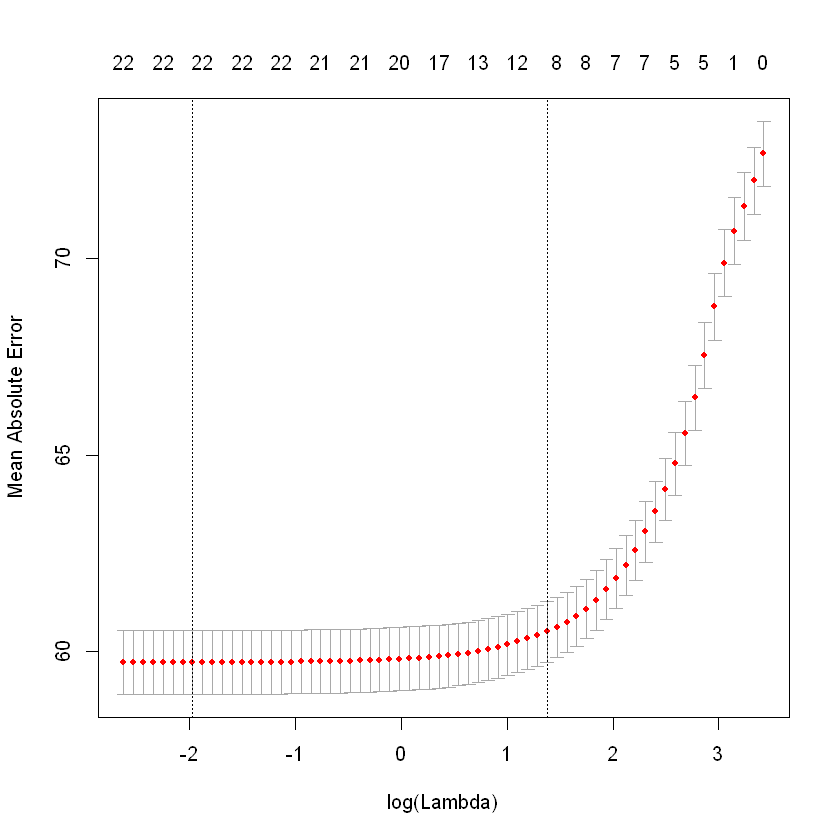

In [15]:
plot(cvfit_pisa_mae)

### Lambda Values for Mean Absolute Error Values

In [16]:
cvfit_pisa_mae$lambda.min

[1] 0.1394421

In [17]:
cvfit_pisa_mae$lambda.1se

[1] 3.97136

In [18]:
cvfit_pisa_mae$lambda[10]

[1] 13.31042

2 possible lambda values are determined by the cv.glmnet(). One of them is used for getting minimum Mean-Squared Error. The other one is determined by looking how many paramater is used in the model. Namely, this lambda value can be beneficial for reducing the possibility of over-fitting model on train dataset. Lastly, one random lambda was selected to compare results for these 3 lambda values.

In [19]:
prediction_pra_mae_pisa_min <- predict(lasso_model_pisa_mae_min, s = cvfit_pisa_mae$lambda.min, newx = test_mat_pisa)
prediction_pra_mae_pisa_1se <- predict(lasso_model_pisa_mae_1se, s = cvfit_pisa_mae$lambda.1se, newx = test_mat_pisa)
prediction_pra_mae_pisa_10th <- predict(lasso_model_pisa_mae_10th, s = cvfit_pisa_mae$lambda[10], newx = test_mat_pisa)

### Performance Measure for Lasso Regression

In [20]:
perf_dt("Pisa Data Set for Lasso Function with min lambda and mse objective", as.numeric(pisa_test$readingScore), prediction_pra_mse_pisa_min)
perf_dt("Pisa Data Set for Lasso Function with 1se lambda and mse objective", as.numeric(pisa_test$readingScore), prediction_pra_mse_pisa_1se)
perf_dt("Pisa Data Set for Lasso Function with 10th lambda and mse objective", as.numeric(pisa_test$readingScore), prediction_pra_mse_pisa_10th)

perf_dt("Pisa Data Set for Lasso Function with min lambda and mae objective", as.numeric(pisa_test$readingScore), prediction_pra_mae_pisa_min)
perf_dt("Pisa Data Set for Lasso Function with 1se lambda and mae objective", as.numeric(pisa_test$readingScore), prediction_pra_mae_pisa_1se)
perf_dt("Pisa Data Set for Lasso Function with 10th lambda and mae objective", as.numeric(pisa_test$readingScore), prediction_pra_mae_pisa_10th)

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Pisa Data Set for Lasso Function with min lambda and mse objective,990,519.8643,88.80043,0.007059544,0.1221016,2.436743,60.67282,0.116709


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Pisa Data Set for Lasso Function with 1se lambda and mse objective,990,519.8643,88.80043,0.00595535,0.1254263,2.486058,62.00751,0.1192763


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Pisa Data Set for Lasso Function with 10th lambda and mse objective,990,519.8643,88.80043,0.00334385,0.1397751,2.733464,68.49831,0.1317619


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Pisa Data Set for Lasso Function with min lambda and mae objective,990,519.8643,88.80043,0.007075397,0.1223196,2.441894,60.80408,0.1169614


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Pisa Data Set for Lasso Function with 1se lambda and mae objective,990,519.8643,88.80043,0.006143376,0.1249088,2.478112,61.78621,0.1188506


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Pisa Data Set for Lasso Function with 10th lambda and mae objective,990,519.8643,88.80043,0.00334385,0.1397751,2.733464,68.49831,0.1317619


# Decision Tree(DT)

In [21]:
set.seed(35)

In [22]:
pisa_train_dt=cbind(pisa_train,dummy_cols(pisa_train$raceeth)[2:8])
pisa_test_dt=cbind(pisa_test,dummy_cols(pisa_test$raceeth)[2:8])
pisa_train_dt[,raceeth:=NULL]
pisa_test_dt[,raceeth:=NULL]

CART 

2414 samples
  29 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2173, 2172, 2172, 2171, 2173, 2174, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE     
  0.00  86.50066  0.1746239  69.09722
  0.01  80.11652  0.2001995  64.42273
  0.02  81.56068  0.1699200  65.52759
  0.03  81.70770  0.1660326  65.69102
  0.04  81.70770  0.1660326  65.69102
  0.05  81.70770  0.1660326  65.69102
  0.06  83.96370  0.1179701  67.73135
  0.07  83.84534  0.1192076  67.71352
  0.08  83.84534  0.1192076  67.71352
  0.09  83.84534  0.1192076  67.71352
  0.10  83.84534  0.1192076  67.71352

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.
CART 

2414 samples
  29 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2172, 2174, 2173, 2173, 2173, 2173, ... 
Resampling results across tuning parameters:

  cp    RMSE   

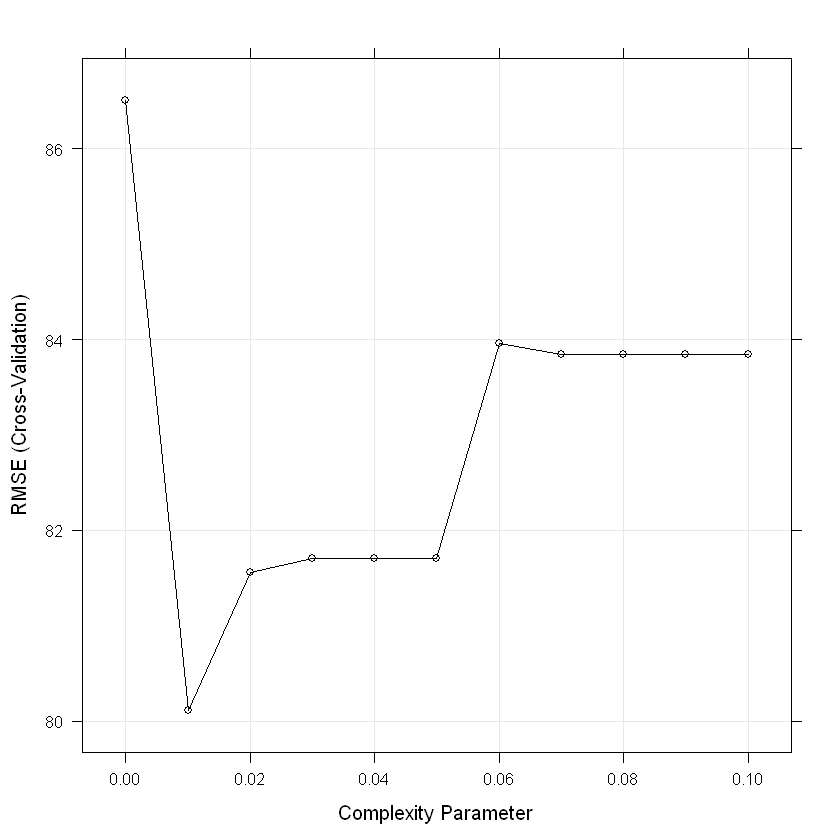

CART 

2414 samples
  29 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2174, 2172, 2173, 2173, 2174, 2173, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE     
  0.00  83.10623  0.2042705  65.92511
  0.01  79.72072  0.2072557  63.77333
  0.02  81.27668  0.1747838  65.12713
  0.03  81.59061  0.1682998  65.65572
  0.04  81.59061  0.1682998  65.65572
  0.05  81.59061  0.1682998  65.65572
  0.06  83.83757  0.1216271  67.73349
  0.07  83.83757  0.1216271  67.73349
  0.08  83.83757  0.1216271  67.73349
  0.09  83.83757  0.1216271  67.73349
  0.10  83.83757  0.1216271  67.73349

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.


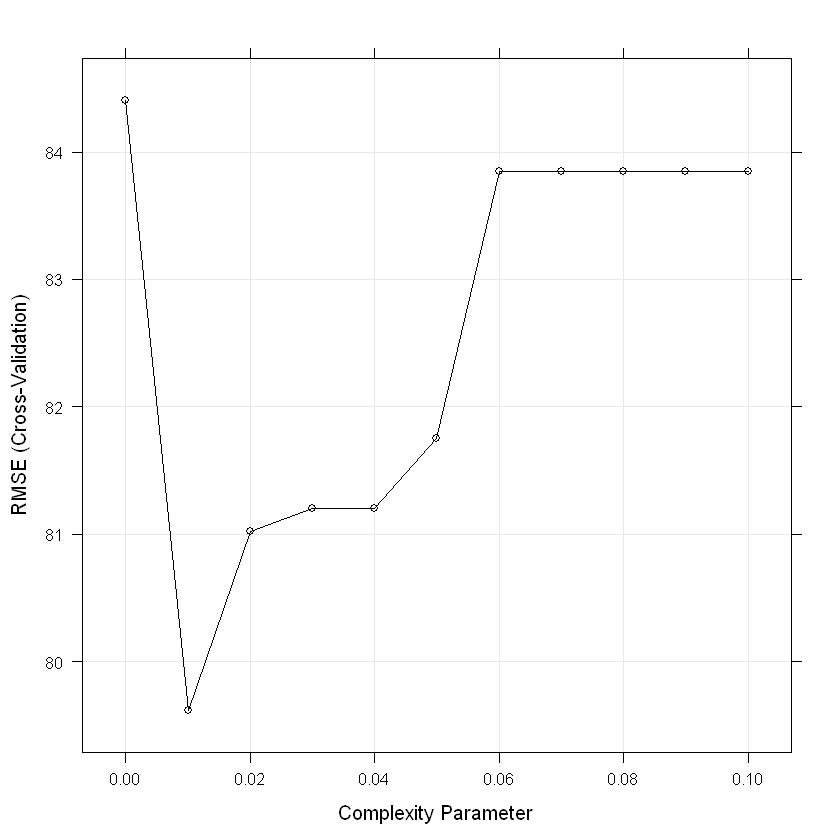

CART 

2414 samples
  29 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2174, 2173, 2173, 2172, 2172, 2172, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE     
  0.00  82.58844  0.2064691  65.76560
  0.01  79.67005  0.2082959  63.81894
  0.02  81.59098  0.1688634  65.54886
  0.03  81.78121  0.1636208  65.76019
  0.04  81.78121  0.1636208  65.76019
  0.05  82.09565  0.1571104  66.13777
  0.06  83.83054  0.1225344  67.63578
  0.07  83.87788  0.1219992  67.74730
  0.08  83.87788  0.1219992  67.74730
  0.09  83.87788  0.1219992  67.74730
  0.10  83.87788  0.1219992  67.74730

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.


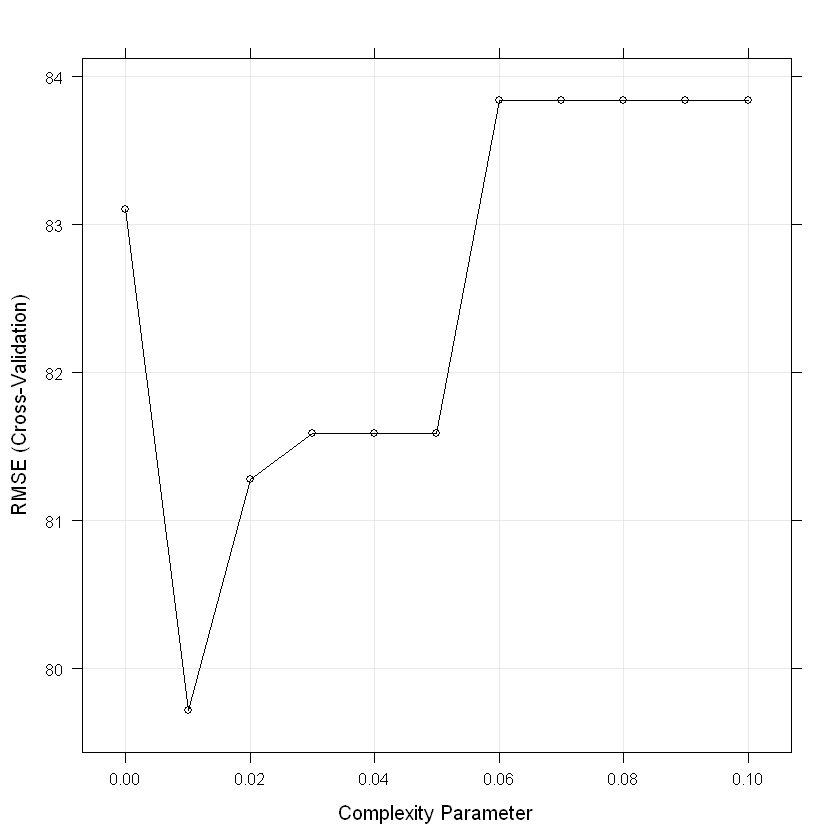

CART 

2414 samples
  29 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2174, 2173, 2171, 2172, 2173, 2173, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE     
  0.00  81.55842  0.2154011  65.39836
  0.01  79.90192  0.2043913  64.34941
  0.02  81.09908  0.1781122  65.14190
  0.03  81.13830  0.1762420  65.29943
  0.04  81.13830  0.1762420  65.29943
  0.05  81.13830  0.1762420  65.29943
  0.06  83.82082  0.1210064  67.73534
  0.07  83.82082  0.1210064  67.73534
  0.08  83.82082  0.1210064  67.73534
  0.09  83.82082  0.1210064  67.73534
  0.10  83.82082  0.1210064  67.73534

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.


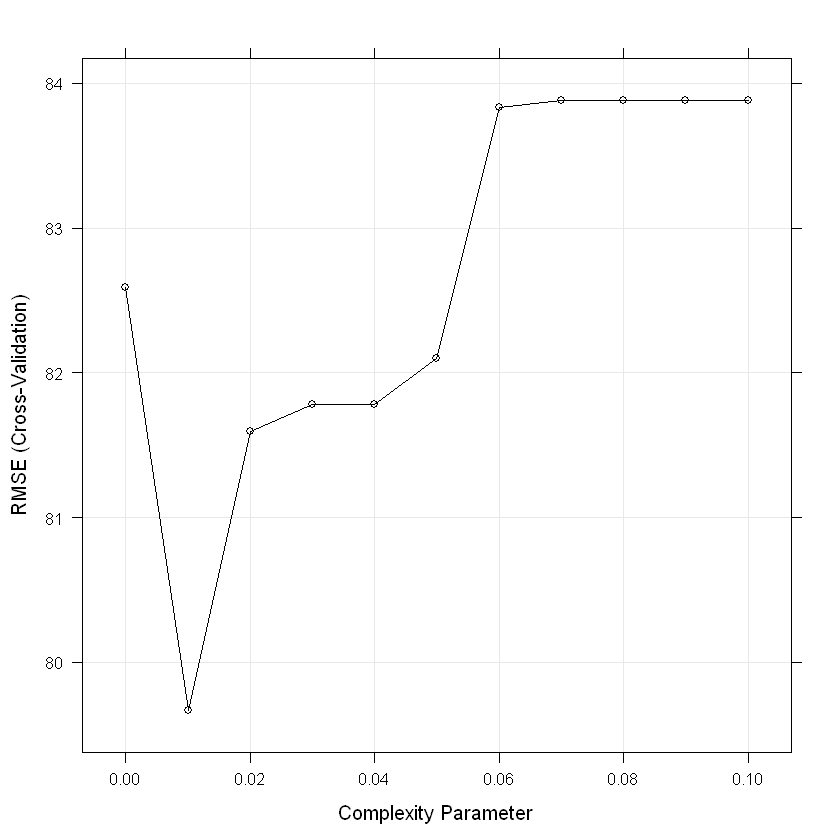

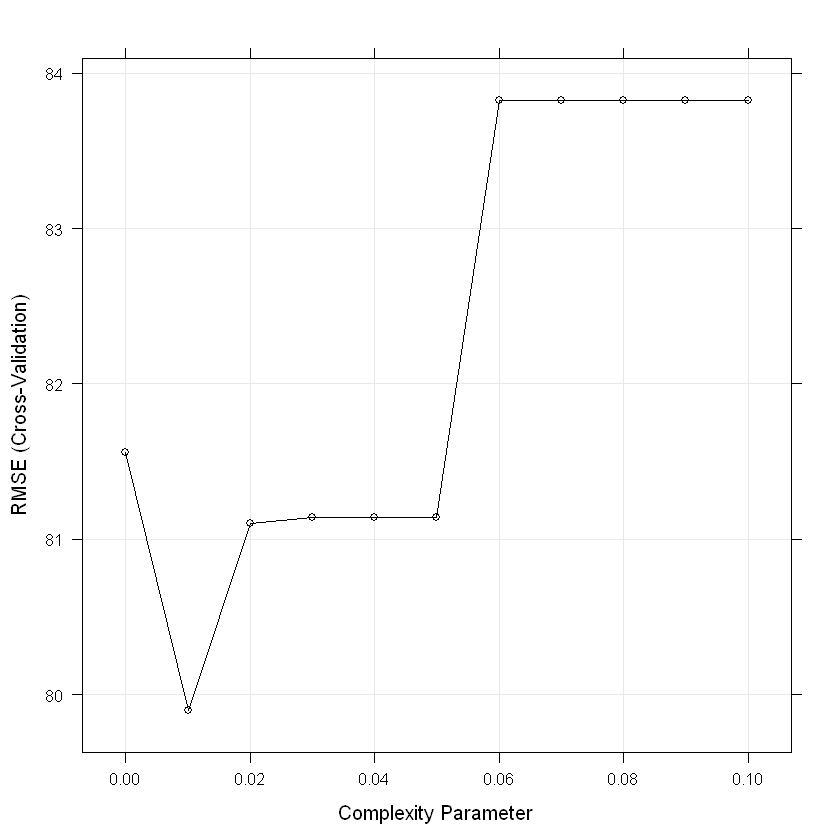

CART 

2414 samples
  29 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2172, 2172, 2170, 2173, 2174, 2173, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE     
  0.00  79.54363  0.2404413  63.35393
  0.01  79.95420  0.2029384  64.18293
  0.02  81.16471  0.1783318  65.44269
  0.03  81.19061  0.1782912  65.34287
  0.04  81.19061  0.1782912  65.34287
  0.05  81.73555  0.1664384  65.78270
  0.06  83.86917  0.1226030  67.75446
  0.07  83.86917  0.1226030  67.75446
  0.08  83.86917  0.1226030  67.75446
  0.09  83.86917  0.1226030  67.75446
  0.10  83.86917  0.1226030  67.75446

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.


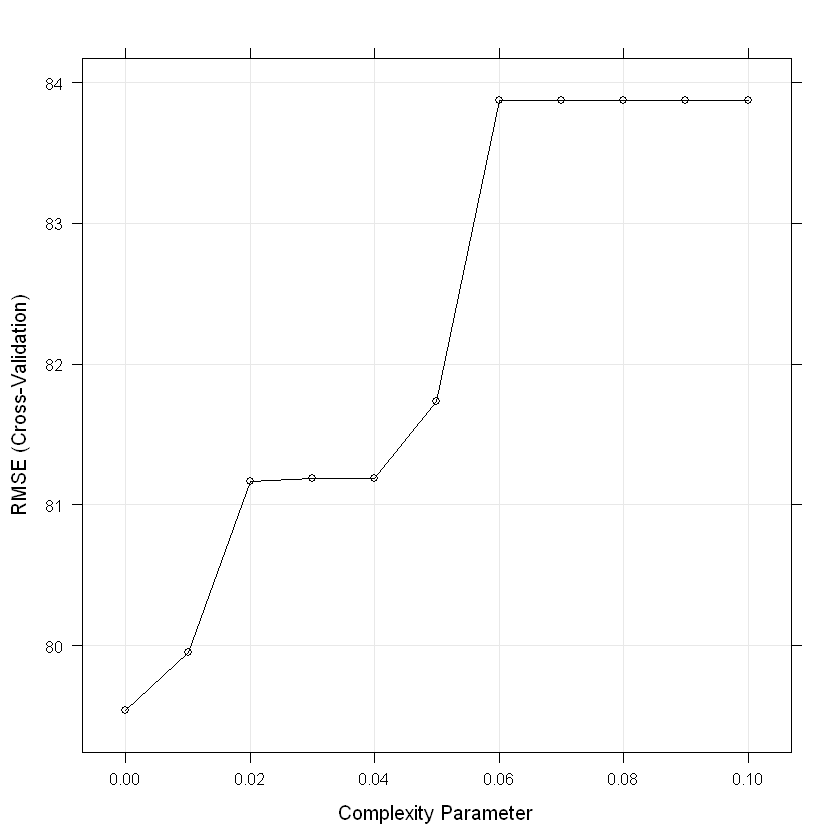

In [23]:
numFolds=trainControl(method="cv",number = 10)
cpGrid=expand.grid(.cp=(0:10)*0.01)
#minbucket_grid=expand.grid(.cp=(5:10))
for(i in 5:10){
    tr=train(readingScore~.,
          data=pisa_train_dt, 
          method="rpart",
          trControl=numFolds,
          tuneGrid= cpGrid,
            # minbucket=minbucket_grid
           control= rpart.control(minbucket = i)
            )
    trellis.par.set(caretTheme())
    print(plot(tr))    
    print(tr)
}

CART 

2414 samples
  29 predictor

No pre-processing
Resampling: Cross-Validated (10 fold) 
Summary of sample sizes: 2173, 2172, 2173, 2173, 2171, 2172, ... 
Resampling results across tuning parameters:

  cp    RMSE      Rsquared   MAE     
  0.00  91.27112  0.1599851  72.71649
  0.01  79.62911  0.2113380  63.93057
  0.02  81.04538  0.1808928  65.05840
  0.03  81.53996  0.1717659  65.64659

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was cp = 0.01.


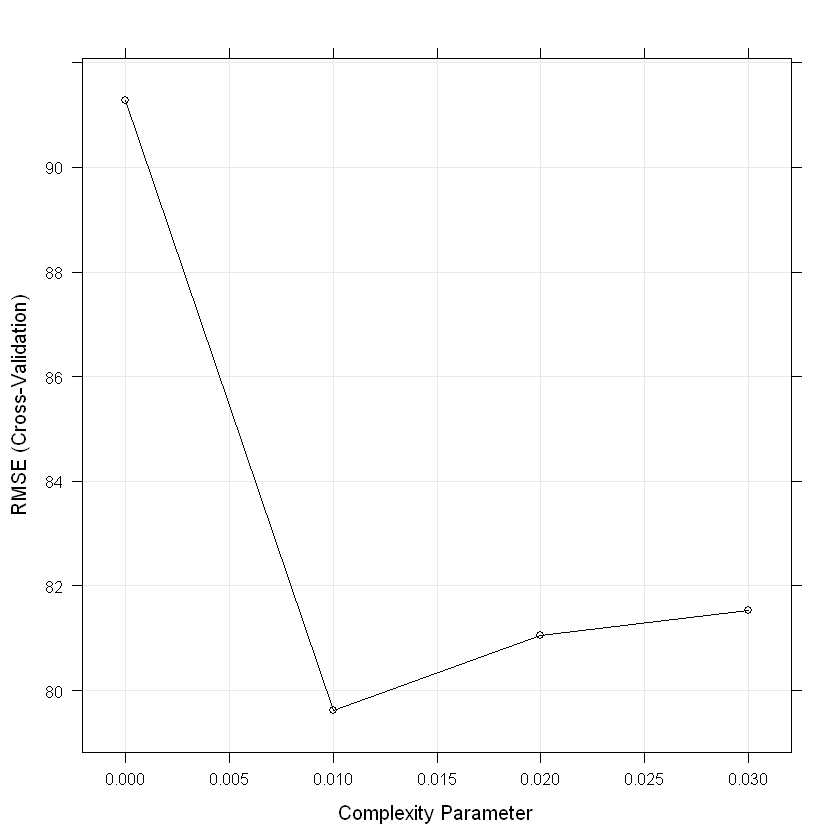

In [24]:
numFolds=trainControl(method="cv",number = 10)
cpGrid=expand.grid(.cp=(0:3)*0.01)
tr=train(readingScore~.,
      data=pisa_train_dt, 
      method="rpart",
      trControl=numFolds,
      tuneGrid= cpGrid,
        # minbucket=minbucket_grid
       control= rpart.control(minsplit = 9)
        )
trellis.par.set(caretTheme())
print(plot(tr))    
print(tr)

expectBachelors               .data_7               .data_4 
         2282409.8932          1070628.9082           542284.6944 
         motherBornUS          fatherBornUS       motherBachelors 
          429366.8017           400091.7925           393018.0663 
                grade               .data_3         englishAtHome 
          293364.1240           269051.2751           257898.8907 
              .data_2       fatherBachelors        read30MinsADay 
          257193.8455           204369.3945           192735.0401 
                 male             preschool          publicSchool 
           43231.9873            41921.9271            34716.5959 
                urban            schoolSize     studentsInEnglish 
           19650.9033            11412.0495             7550.3792 
minutesPerWeekEnglish 
             922.1772

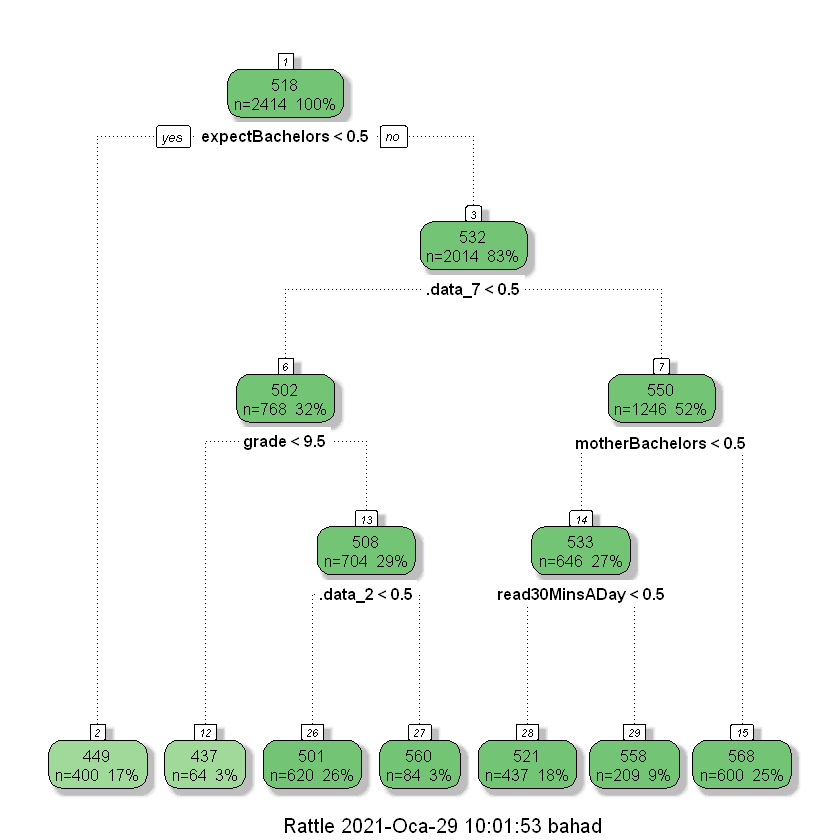

In [25]:
reg_tree_pisa=tr$finalModel
fancyRpartPlot(reg_tree_pisa)
reg_tree_pisa$variable.importance

In [26]:
predicted_pisa_dt=predict(reg_tree_pisa,newdata=pisa_test_dt)

### Performanca Measure

In [27]:
perf_dt("Decision Tree with CV for Pisa Dataset",pisa_test_dt$readingScore,as.numeric(predicted_pisa_dt))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Decision Tree with CV for Pisa Dataset,990,519.8643,88.80043,0.007325851,0.1262667,2.506513,62.69629,0.1206013


## Random Forest(RF)

In [40]:
library(ranger)

In [29]:
fitControl=trainControl(method = "repeatedcv",
                           number = 10) 

In [30]:
rf_grid=expand.grid(mtry=c(4,8,10,15),
                   splitrule = c("variance"),
                   min.node.size= c(5))
rf_grid  

mtry,splitrule,min.node.size
4,variance,5
8,variance,5
10,variance,5
15,variance,5


In [31]:
rf_fit=train(readingScore ~ ., data = pisa_train, 
                 method = "ranger", 
                 trControl = fitControl, num.trees=500,
                 tuneGrid = rf_grid) 

Random Forest 

2414 samples
  23 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 1 times) 
Summary of sample sizes: 2173, 2172, 2172, 2173, 2173, 2173, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE     
   4    74.22778  0.3127169  59.68398
   8    74.86137  0.2988596  60.03758
  10    75.34474  0.2908063  60.46137
  15    75.50474  0.2895483  60.54514

Tuning parameter 'splitrule' was held constant at a value of variance

Tuning parameter 'min.node.size' was held constant at a value of 5
RMSE was used to select the optimal model using the smallest value.
The final values used for the model were mtry = 4, splitrule = variance
 and min.node.size = 5.

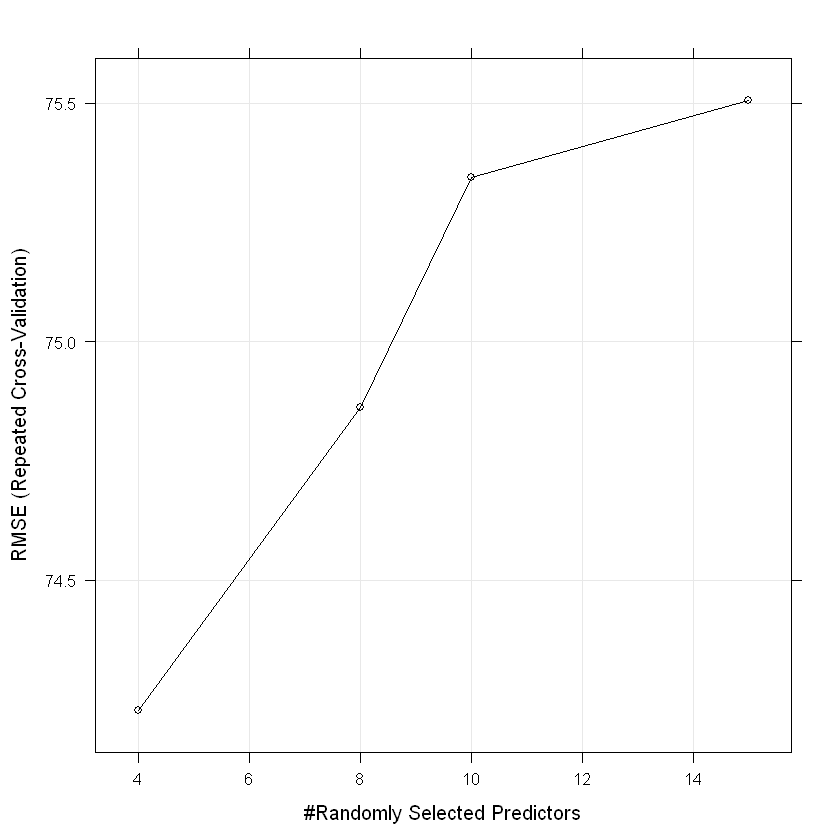

In [32]:
rf_fit
plot(rf_fit)

In [33]:
RandomForest_pisa=predict(rf_fit,newdata=pisa_test)

### Performanca Measure

In [34]:
perf_dt("First Data Set for Random Forest", as.numeric(RandomForest_pisa), as.numeric(pisa_test$readingScore))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
First Data Set for Random Forest,990,517.8192,45.48294,-0.003949342,0.1157326,2.383545,59.41911,0.1147487


# Stochastic Gradient Boosting(SGB)

In [35]:
set.seed(35)

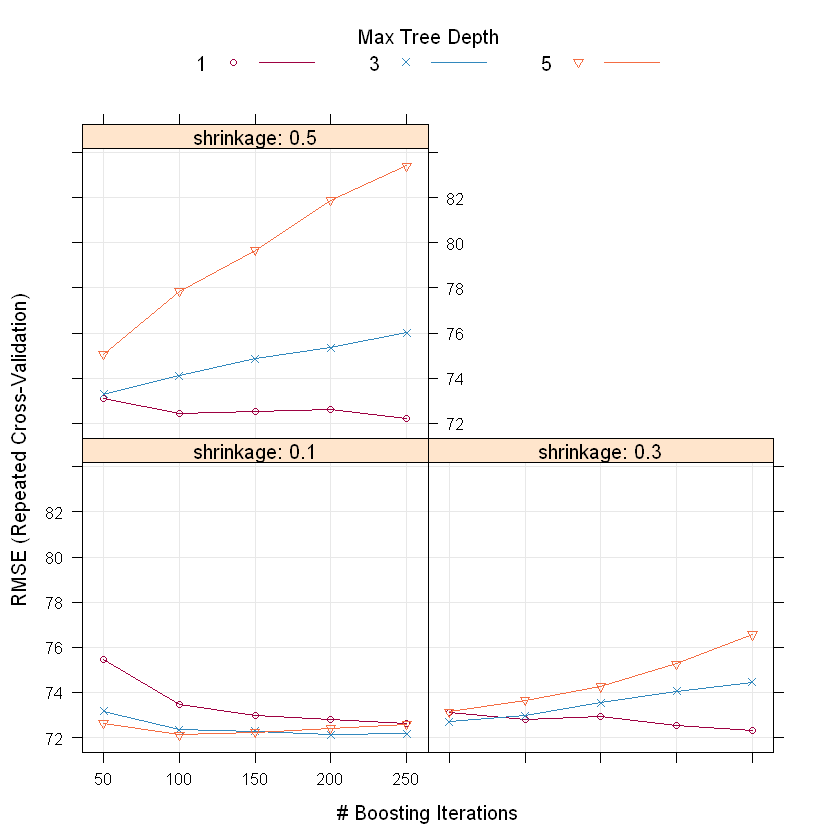

In [36]:
gbmGrid=expand.grid(interaction.depth = c(1, 3, 5), 
                        n.trees = (1:5)*50, 
                        shrinkage = c(0.1, 0.3, 0.5),
                        n.minobsinnode = 20)
                                                                

gbm_fit=train(readingScore ~ ., data = pisa_train, 
                 method = "gbm", 
                 trControl = fitControl,  
                 tuneGrid = gbmGrid,
                 verbose=F) #verbose is an argument from gbm, prints to screen

plot(gbm_fit)

In [37]:
predicted_pisa_sgb=predict(gbm_fit,pisa_test)

### Performanca Measure

In [38]:
perf_dt("First Data Set for Stochastic Gradient Boosting", as.numeric(predicted_pisa_sgb), as.numeric(pisa_test$readingScore))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
First Data Set for Stochastic Gradient Boosting,990,516.5296,52.44005,-0.00645595,0.1154572,2.364434,58.9861,0.1141969


# General Result for 4 Method for Pisa Reading Results

In [39]:
perf_dt("Pisa Data Set for Lasso Function with min lambda and mse objective", as.numeric(pisa_test$readingScore), prediction_pra_mse_pisa_min)
perf_dt("Decision Tree with CV for Pisa Dataset",pisa_test_dt$readingScore,as.numeric(predicted_pisa_dt))
perf_dt("First Data Set for Random Forest", as.numeric(RandomForest_pisa), as.numeric(pisa_test$readingScore))
perf_dt("First Data Set for Stochastic Gradient Boosting", as.numeric(predicted_pisa_sgb), as.numeric(pisa_test$readingScore))

name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Pisa Data Set for Lasso Function with min lambda and mse objective,990,519.8643,88.80043,0.007059544,0.1221016,2.436743,60.67282,0.116709


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
Decision Tree with CV for Pisa Dataset,990,519.8643,88.80043,0.007325851,0.1262667,2.506513,62.69629,0.1206013


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
First Data Set for Random Forest,990,517.8192,45.48294,-0.003949342,0.1157326,2.383545,59.41911,0.1147487


name,n,mean,sd,FBias,MAPE,RMSE,MAD,WMAPE
First Data Set for Stochastic Gradient Boosting,990,516.5296,52.44005,-0.00645595,0.1154572,2.364434,58.9861,0.1141969
